RFBOutputContext()


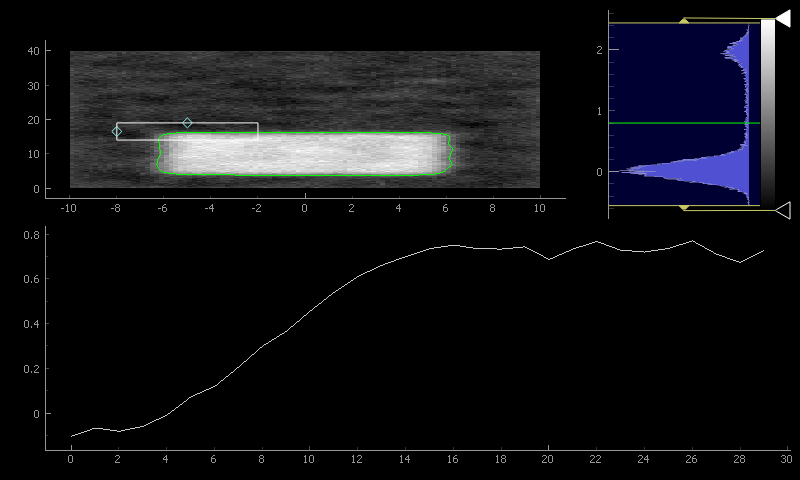

GraphicsLayoutWidget(css_height='480px', css_width='800px')

In [2]:
"""
Demonstrates common image analysis tools.

Many of the features demonstrated here are already provided by the ImageView
widget, but here we present a lower-level approach that provides finer control
over the user interface.
"""
from pyqtgraph.jupyter import GraphicsLayoutWidget
import ipywidgets
from IPython.display import display

import pyqtgraph as pg
from pyqtgraph.Qt import QtCore, QtGui
import numpy as np


# Interpret image data as row-major instead of col-major
pg.setConfigOptions(imageAxisOrder='row-major')

pg.mkQApp()
win = GraphicsLayoutWidget(css_width="800px", css_height="480px")

# A plot area (ViewBox + axes) for displaying the image
p1 = win.addPlot(title="")

# Item for displaying image data
img = pg.ImageItem()
p1.addItem(img)

# Custom ROI for selecting an image region
roi = pg.ROI([-8, 14], [6, 5])
roi.addScaleHandle([0.5, 1], [0.5, 0.5])
roi.addScaleHandle([0, 0.5], [0.5, 0.5])
p1.addItem(roi)
roi.setZValue(10)  # make sure ROI is drawn above image

# Isocurve drawing
iso = pg.IsocurveItem(level=0.8, pen='g')
iso.setParentItem(img)
iso.setZValue(5)

# Contrast/color control
hist = pg.HistogramLUTItem()
hist.setImageItem(img)
win.addItem(hist)

# Draggable line for setting isocurve level
isoLine = pg.InfiniteLine(angle=0, movable=True, pen='g')
hist.vb.addItem(isoLine)
hist.vb.setMouseEnabled(y=False) # makes user interaction a little easier
isoLine.setValue(0.8)
isoLine.setZValue(1000) # bring iso line above contrast controls

# Another plot area for displaying ROI data
win.nextRow()
p2 = win.addPlot(colspan=2)
p2.setMaximumHeight(250)


# Generate image data
data = np.random.normal(size=(200, 100))
data[20:80, 20:80] += 2.
data = pg.gaussianFilter(data, (3, 3))
data += np.random.normal(size=(200, 100)) * 0.1
img.setImage(data)
hist.setLevels(data.min(), data.max())

# build isocurves from smoothed data
iso.setData(pg.gaussianFilter(data, (2, 2)))

# set position and scale of image
tr = QtGui.QTransform()
img.setTransform(tr.scale(0.2, 0.2).translate(-50, 0))

# zoom to fit imageo
p1.autoRange()  


# Callbacks for handling user interaction
def updatePlot():
    global img, roi, data, p2
    selected = roi.getArrayRegion(data, img)
    p2.plot(selected.mean(axis=0), clear=True)

roi.sigRegionChanged.connect(updatePlot)
updatePlot()

def updateIsocurve():
    global isoLine, iso
    iso.setLevel(isoLine.value())

isoLine.sigDragged.connect(updateIsocurve)

def imageHoverEvent(event):
    """Show the position, pixel, and value under the mouse cursor.
    """
    if event.isExit():
        p1.setTitle("")
        return
    pos = event.pos()
    i, j = pos.y(), pos.x()
    i = int(np.clip(i, 0, data.shape[0] - 1))
    j = int(np.clip(j, 0, data.shape[1] - 1))
    val = data[i, j]
    ppos = img.mapToParent(pos)
    x, y = ppos.x(), ppos.y()
    p1.setTitle("pos: (%0.1f, %0.1f)  pixel: (%d, %d)  value: %.3g" % (x, y, i, j, val))

# Monkey-patch the image to use our custom hover function. 
# This is generally discouraged (you should subclass ImageItem instead),
# but it works for a very simple use like this. 
img.hoverEvent = imageHoverEvent


# disable HistogramLUTItem right-click context menus to prevent crashes
hist.vb.setMenuEnabled(False)
hist.gradient.showMenu = lambda ev : None
display(win)
